In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/pr/r9s7fv8d3hl7zl078q3rzs_00000gn/T/ipykernel_1438/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Setup Inspector for measurement
from sqlalchemy import create_engine, inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for x in columns:
    print(x['name'], x['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
print(recent_date)

2017-08-23


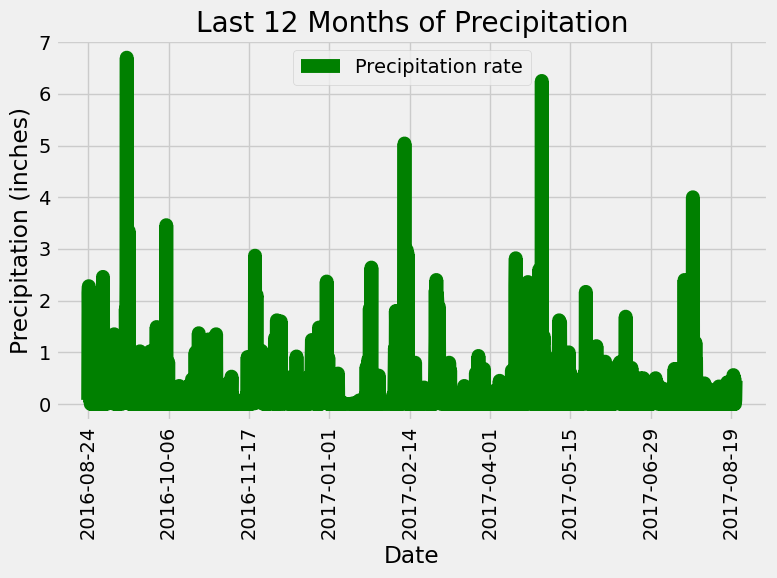

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_back = dt.datetime.strptime(recent_date, "%Y-%m-%d") -dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_rate = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_back).\
    order_by(Measurement.date).all()
    
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_rate)
prcp_df = prcp_df.rename(columns ={"prcp":"Precipitation rate"})

# Sort the dataframe by date
prcp_df.sort_values('date', ascending=True)
prcp_df = prcp_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(y="Precipitation rate", x="date", color ='g', figsize=(8,6), legend=True, linewidth=10, grid=True)
plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation')
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation rate
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
#Setup inspector for station
inspector = inspect(engine)
columns = inspector.get_columns('station')
for x in columns:
    print(x['name'], x['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count(Station.station.distinct())).scalar()
print(num_stations)

9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_join=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(station_join)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_id = station_join[0][0]
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station_id).first()

print("Most Active Station ID:", active_station_id)
print("Lowest Temperature:", temp_stats[0])
print("Highest Temperature:", temp_stats[1])
print("Average Temperature:", temp_stats[2])

Most Active Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


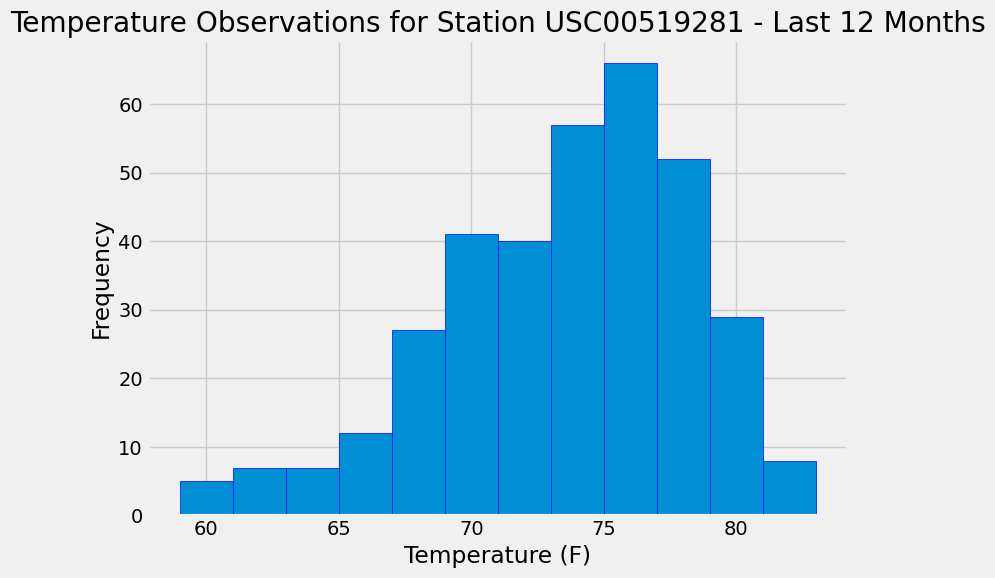

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_back_2 = dt.datetime.strptime(recent_date, "%Y-%m-%d") -dt.timedelta(days=365)

query_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == active_station_id, Measurement.date >= year_back_2).all()

#Create df for histogram
temp_df = pd.DataFrame(query_temp, columns=['temperature'])

#Plot histogram
plt.figure(figsize=(8,6))
plt.hist(temp_df['temperature'], bins=12, edgecolor='blue')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {active_station_id} - Last 12 Months')
plt.tight_layout()
plt.show()

# Close Session

In [18]:
# Close Session
session.close()